# Tracking in Microscopy v2

## Student : DI MARIA, Franco Martin
franco.di-maria@imt-atlantique.net

# Loading of python libraries

In [1]:
# !pip install numpy
# !pip install -U scikit-image
# !pip install ipywidgets
# !pip install matplotlib

In [2]:
from ipywidgets import widgets
from ipywidgets import interact, fixed
from skimage.draw import circle_perimeter
from skimage.draw import line
import matplotlib.pyplot as plt
import skimage.io as io
import numpy as np
import math

# Definition of classes and functions

In [3]:


class Spot:
    def __init__(self, x, y, t, value, matched=None, daughterOf=None):
        self.x = x # int: position x --> column 
        self.y = y # int: position y --> raw
        self.t = t # int: position t
        self.value = value # float: intensity value at Im(x, y, t) # Question 8
        self.matched = matched # Spot: linked detection in the frame t+1
    
    def distance(self, spot): # Spot spot
        return np.sqrt(((spot.x - self.x)**2) + ((spot.y - self.y)**2))
    
    def draw(self, size, stack_results): 
        # stack_results: image in which we draw the detections and the trajectories. Shape (T,W,L,C)
        # size: radius of the circle
        rr, cc = circle_perimeter(self.y, self.x, size, shape=(stack_results.shape[1], stack_results.shape[2]))
        stack_results[self.t,rr, cc, :] = (255, 0, 0)

In [4]:
class Trajectory: # A partir de la question 6
    def __init__(self): 
        self.list_spots = [] # a trajectory is a list of spots
    
    def add(self, spot): 
        self.list_spots.append(spot) # a trajectory is a list of spots
        
    def last_spot(self): # return the last spot added to the trajectory
        return self.list_spots[-1]
    
    def draw(self, stack_results):
        color = list(np.random.choice(range(256), size=3))
        nbSpots = len(self.list_spots)
        for i in range(nbSpots-1):
            spot1 = self.list_spots[i]
            spot2 = self.list_spots[i+1]
            rr, cc = line(spot1.y, spot1.x, spot2.y, spot2.x)
            stack_results[:, rr, cc, :] = color

In [5]:
def plot_image(image, title):
    plt.imshow(image, cmap=plt.cm.gray)
    plt.axis('off')
    plt.title(title)
    plt.show()
    
def plot_image_RGB(image, title):
    plt.imshow(image.astype(np.uint8))
    plt.axis('off')
    plt.title(title)
    plt.show()
    
def plot_stack(image, index, title):
    plt.imshow(image[index], cmap=plt.cm.gray)
    plt.axis('off')
    plt.title(title)
    plt.show()
    
def plot_trajectories(image, index, title):
    plt.imshow(image[index].astype(np.uint8))
    plt.axis('off')
    plt.title(title)
    plt.show()

# Loading of the sequence of images

### <span style="color:blue">Question 1</span>

In [6]:
im = io.imread("moving-particles-sample1.tif")
nT = im.shape[0]
interact(plot_stack, image=fixed(im), index=(0,nT-1,1), title=fixed("Sequence of images 1"));

interactive(children=(IntSlider(value=29, description='index', max=59), Output()), _dom_classes=('widget-inter…

# Spot detection

### <span style="color:blue">Question 2: DoG filter</span>

In [7]:
import skimage.filters as filters

def DOG_fct(image, sigma, plot=False): # Slide 9
    sigma1 = sigma
    sigma2 = np.sqrt(2) * sigma1
    g1 = filters.gaussian(image, sigma1, preserve_range=True)
    g2 = filters.gaussian(image, sigma2, preserve_range=True) 
    DOG_image = g1 - g2
        
    if plot==True:
        plot_image(DOG_image, "DOG filtering")
    
    else:
        return DOG_image

### Visualization

In [8]:
interact(DOG_fct, image=fixed(im[0]), sigma=(1, 10 ,1), plot=fixed(True));

interactive(children=(IntSlider(value=5, description='sigma', max=10, min=1), Output()), _dom_classes=('widget…

### <span style="color:blue">Question 3</span>

In [9]:
sigma_1 = 2

By setting `sigma` equal to `2`, we can clearly discriminate particles from the background.

### <span style="color:blue">Question 4: local maxima</span>

In [10]:
from skimage.color import gray2rgb

from skimage.feature import peak_local_max

def detect_local_maxima(DOG_image, threshold, size=3, original_image=None, plot=False):
    detected_spots = peak_local_max(DOG_image, threshold_abs=threshold, exclude_border=False)
    
    if plot==True:
        image_RGB = gray2rgb(original_image)
        for spot in detected_spots:
            rr, cc = circle_perimeter(spot[0], spot[1], size, shape=(original_image.shape[0], original_image.shape[1]))
            image_RGB[rr, cc, :] = (255, 0, 0)
        plot_image_RGB(image_RGB, "Spot detection")
    else:
        return detected_spots

### Visualization

In [11]:
DOG_image = DOG_fct(im[0], sigma_1)
interact(detect_local_maxima, DOG_image=fixed(DOG_image), threshold=(1,20,1), original_image=fixed(im[0]), plot=fixed(True));

interactive(children=(IntSlider(value=10, description='threshold', max=20, min=1), IntSlider(value=3, descript…

### <span style="color:blue">Question 5</span>

In [12]:
threshold_1 = 5

By setting `threshold` equal to `5` we can easily detect particles positions from other non relevant spot

# Real time tracking algorithm using a nearest neighbor search
 
1. Object/spot detection on frame t
    1. Compute DoG filter of the frame t
    2. Detect the local maxima
2. Link the detections between the frames t and t - 1

### <span style="color:blue">Question 6, 7, 8, 9</span>

In [13]:
class ParticleTracker():
    def __init__(self, im, sigma, threshold, velocity):
        self.im = im
        self.nT = im.shape[0]
        self.sigma = sigma
        self.threshold = threshold
        self.velocity = velocity
        self.stack_results = self._init_stack_results()
        self.trajectories  = self._build_trajectories()
    
    def _init_stack_results(self):
        stack_results = np.zeros((self.nT, self.im.shape[1], self.im.shape[2], 3), dtype=np.double)
        for t in range(self.nT):
            stack_results[t] = gray2rgb(self.im[t])
        return stack_results
    
    def _init_trajectories(self):
        current_t = 0

        # Object/spot detection on the first frame
            # 1) Compute DOG filter of the first frame
        DOG_image = DOG_fct(self.im[current_t], self.sigma)

            # 2) Detect the local maxima
        detected_spots = detect_local_maxima(DOG_image, self.threshold)

        nbSpots = detected_spots.shape[0]
        # print(str(nbSpots) + " points detected on frame t=0")

            # 3) Convert the dected_spots into Spot object and draw it on stack_results
        spots = []
        for (row, column) in detected_spots:
            spot = Spot(column, row, current_t, self.im[current_t, row,column])
            spot.draw(3, self.stack_results)
            spots.append(spot)

            # 4) Initialize the trajectories
        trajectories = []
        for spot in spots:
            trajectory = Trajectory()
            trajectory.add(spot)
            trajectories.append(trajectory)

        return trajectories
    
    def _build_trajectories(self):
        trajectories = self._init_trajectories()

        for current_t in range(1, self.nT, 1): #range(start, stop (not included), step)
            # Object/spot detection on the frame current_t
                # 1) Compute DOG filter of the frame current_t
            DOG_image = DOG_fct(self.im[current_t], self.sigma)

                # 2) Detect the local maxima
            detected_spots = detect_local_maxima(DOG_image, self.threshold)

            nbSpots = detected_spots.shape[0]
            # print(str(nbSpots) + " points detected on the frame t=" + str(current_t))    

                # 3) Convert the dected_spots into Spot object and draw it on stack_results
            spots = []
            for (row, column) in detected_spots:
                spot = Spot(column, row, current_t, self.im[current_t,row,column])
                spot.draw(3, self.stack_results)
                spots.append(spot)

                # 4) Build the trajectory : linking of the detections between the frames current_t and current_t - 1 using a Nearest neighbor search
            for spot in spots: 
                near_trajectories = []
                near_trajectories_distances = []

                for trajectory in trajectories:
                    last_spot = trajectory.last_spot() # Extract the last spot of the trajectory
                    
                    if(last_spot.t == current_t-1): # Check that the last spot of the current trajectories belongs to the frame current_t - 1, otherwise they can not be linked 
                        if(last_spot.matched == None): # Check that the last spot was not linked to another detection yet
                            near_trajectories.append(trajectory)
                            near_trajectories_distances.append(spot.distance(last_spot))

                if  (len(near_trajectories) > 0) and (
                    np.min(near_trajectories_distances) <= self.velocity):
                    near_trajectory = near_trajectories[np.argmin(near_trajectories_distances)]
                    near_trajectory.last_spot().matched = spot
                    near_trajectory.add(spot)
                else: # else start a new trajectory with this spot
                    new_trajectory = Trajectory()
                    new_trajectory.add(spot)
                    trajectories.append(new_trajectory)
            
        return trajectories

    def count_trajectories(self):
        return len(self.trajectories)

    def plot_trajectories(self):
        for trajectory in self.trajectories:
            trajectory.draw(self.stack_results)
            
        interact(plot_trajectories, image=fixed(self.stack_results), index=(0,nT-1,1), title=fixed("Trajectories"));

        

In [14]:
tracker_1_30  = ParticleTracker(im, sigma_1, threshold_1, velocity=30)
print(f"{tracker_1_30.count_trajectories() = }")
tracker_1_30.plot_trajectories()

tracker_1_30.count_trajectories() = 54


interactive(children=(IntSlider(value=29, description='index', max=59), Output()), _dom_classes=('widget-inter…

In [15]:
tracker_1_11  = ParticleTracker(im, sigma=sigma_1, threshold=threshold_1, velocity=11)
print(f"{tracker_1_11.count_trajectories() = }")
tracker_1_11.plot_trajectories()

tracker_1_11.count_trajectories() = 54


interactive(children=(IntSlider(value=29, description='index', max=59), Output()), _dom_classes=('widget-inter…

### <span style="color:blue">Question 9</span>
Are you happy with the results? Otherwise you can play with the velocity parameter. Report the final value used for the velocity and justify your choice.

In [16]:
velocity_1 = 11

By keeping the original velocity equal to `54` we achieve a total number of trajectories equal to `54`. Assuming that this is the correct number of trajectories, we reduced the `velocity` until reaching its minimum value for the same number of trajectoires. Therefore, we choose a velocity equal to `11` for these sequence of images and as reference for the following exercices.

# Saving the results

In [17]:
io.imsave("stack_results1.tif", tracker_1_11.stack_results)

### <span style="color:blue">Question 10</span>
Apply your algorithm on the sequence of images "moving-particles-sample2.tif". What do you notice? Why do you think that the results are altered? Play with the parameters of your algorithm to obtain good results and report your final parameters value. Justify your answers/choices.

In [18]:
im_2 = io.imread("moving-particles-sample2.tif")
nT_2 = im.shape[0]
interact(plot_stack, image=fixed(im_2), index=(0,nT_2-1,1), title=fixed("Sequence of images 2"));

interactive(children=(IntSlider(value=29, description='index', max=59), Output()), _dom_classes=('widget-inter…

We can see that this new sequence of images is **noisier** than the previous one. Another parametrization of the `sigma` and `threshold` may be needed to correctly identify the previous trajectories.

In [19]:
interact(DOG_fct, image=fixed(im_2[0]), sigma=(1, 10 ,1), plot=fixed(True));

interactive(children=(IntSlider(value=5, description='sigma', max=10, min=1), Output()), _dom_classes=('widget…

In [20]:
sigma_2 = 3

In this case, we choose a `sigma` equal to `3` in order to highlight the particles from the noisy background 

In [21]:
DOG_image_2 = DOG_fct(im_2[0], sigma_2)
interact(detect_local_maxima, DOG_image=fixed(DOG_image_2), threshold=(1,20,1), original_image=fixed(im_2[0]), plot=fixed(True));

interactive(children=(IntSlider(value=10, description='threshold', max=20, min=1), IntSlider(value=3, descript…

In [22]:
threshold_2 = 6

Similarly, we move the `threshold` to `6` to correctly detect the particles from the each frame. 

In [23]:
tracker_2  = ParticleTracker(im_2, sigma_2, threshold_2, velocity=11)
print(f"{tracker_2.count_trajectories() = }")
tracker_2.plot_trajectories()

tracker_2.count_trajectories() = 57


interactive(children=(IntSlider(value=29, description='index', max=59), Output()), _dom_classes=('widget-inter…

Unfortunately, even after fine tuning the detection parameters `sigma` and `threshold`, we didn't arrive to the exact same number of trajectories as in the case without noise. Netherless, this does not mean that this amount of trajectoires is wrong but maybe that the one assumed in the first case is not totally right.

In [24]:
io.imsave("stack_results2.tif", tracker_2.stack_results)

### <span style="color:blue">Question 11</span>
Same question with "moving-particles-sample3.tif". Justify your answer.

In [25]:
im_3 = io.imread("moving-particles-sample3.tif")
nT_3 = im.shape[0]
interact(plot_stack, image=fixed(im_3), index=(0,nT_3-1,1), title=fixed("Sequence of images"));

interactive(children=(IntSlider(value=29, description='index', max=59), Output()), _dom_classes=('widget-inter…

Looking at the first frames of this sequence, we can notice the same particles as in sequence `1` (and `2`). However, it seems that they move faster for frame to frame and, so, having the same amount of frames, the new sequences goes further into the future. Therefore, in this case, detection parameters should stay steady while increasing the `velocity` from frame to frame. 

In [26]:
interact(DOG_fct, image=fixed(im_3[0]), sigma=(1, 10 ,1), plot=fixed(True));

interactive(children=(IntSlider(value=5, description='sigma', max=10, min=1), Output()), _dom_classes=('widget…

In [27]:
sigma_3 = 2

In [28]:
DOG_image_3 = DOG_fct(im_3[0], sigma_3)
interact(detect_local_maxima, DOG_image=fixed(DOG_image_3), threshold=(1,20,1), original_image=fixed(im_3[0]), plot=fixed(True));

interactive(children=(IntSlider(value=10, description='threshold', max=20, min=1), IntSlider(value=3, descript…

In [29]:
threshold_3 = 5

In [30]:
tracker_3  = ParticleTracker(im_3, sigma=sigma_3, threshold=threshold_3, velocity=31)
print(f"{tracker_3.count_trajectories() = }")
tracker_3.plot_trajectories()

tracker_3.count_trajectories() = 55


interactive(children=(IntSlider(value=29, description='index', max=59), Output()), _dom_classes=('widget-inter…

As expected, a considerable increase in the velocity up to `31` was needed to equal the same result as in sequence `1`, by keeping the same detection parameters.

In [31]:
io.imsave("stack_results3.tif", tracker_3.stack_results)

# Mean square displacement analysis (MSD)

### <span style="color:blue">Question 12</span>
Compute the MSD for one particle (one trajectory).

In [32]:
def compute_MSD_step(trajectory, step):
    square_displacements = []
    for i in range(len(trajectory) - step):
        spot1 = trajectory[i]
        spot2 = trajectory[i + step]
        square_displacements.append(spot1.distance(spot2)**2)
    return np.mean(square_displacements)


def compute_MSD(trajectory):
    trajectory_ = trajectory.list_spots 
    MSD = []
    for step in range(1, len(trajectory_)):
        MSD.append(compute_MSD_step(trajectory_, step))
    return np.array(MSD)

### <span style="color:blue">Question 13</span>
Plot on the same figure the MSD curve of each trajectory.

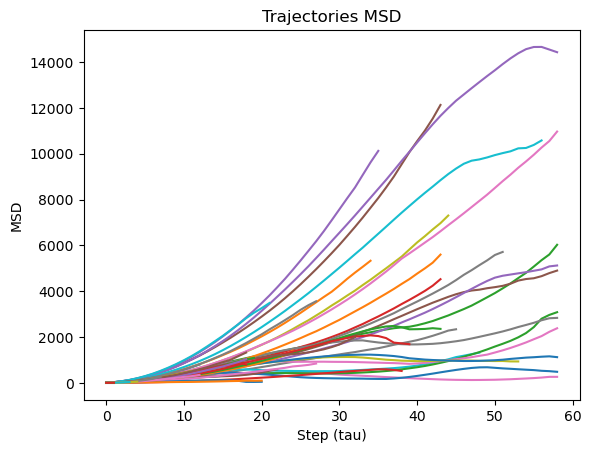

In [33]:
trajectories = tracker_1_11.trajectories

MSDs = []
for trajectory in trajectories:
    MSD = compute_MSD(trajectory)
    MSDs.append(MSD)
    plt.plot(MSD)

plt.xlabel("Step (tau)")
plt.ylabel("MSD")
plt.title("Trajectories MSD")
plt.show()

### <span style="color:blue">Question 14</span>
Compute the average MSD of all trajectories and plot the resulting curve.

In [34]:
def avg_MSD(MDSs):
    lens = [len(i) for i in MDSs]
    arr = np.ma.empty((len(MDSs), np.max(lens)))
    arr.mask = True
    for idx, MSD in enumerate(MDSs):
        arr[idx, :len(MSD)] = MSD
    return arr.mean(axis = -2)

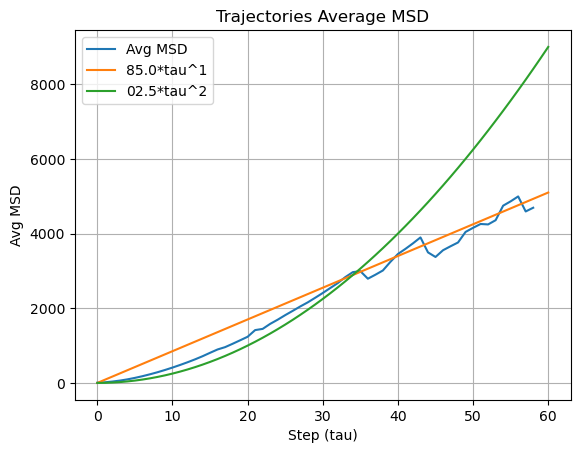

In [45]:
plt.plot(avg_MSD(MSDs), label="Avg MSD")
plt.plot([85*tau for tau in range(61)], label="85.0*tau^1")
plt.plot([2.5*tau**2 for tau in range(61)], label="02.5*tau^2")
plt.xlabel("Step (tau)")
plt.ylabel("Avg MSD")
plt.title("Trajectories Average MSD")
plt.legend()
plt.grid()
plt.show()

### <span style="color:blue">Question 15</span>
According to you, the movement of the particles correspond to directed motions (superdiffusion), Brownian motions (normal diffusion) or confined movements (subdiffusion)? Justify your answer.

Plot in question `14` shows us that the average MSD follows a superdiffusion (directed motion) behaviour from tau `0` to `35`, as it aligns with the curve `f(tau) = 2.5*tau^2`. From tau `35` to `60`, the average MSD change to a normal diffusion (Brownian motion) as it oscillates around the curve `f(tau) = 85*tau^1`. This fluctuation for higher values of tau can be explained as there are few trajectories long enough to contribute to the average MSD on this last part. Since there is not enough data, the behaviour of the averages MSD turns random at this stage.  